In [1]:
import os
import numpy as np
from cnn_finetune import make_model
import pandas as pd
from skimage import io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import transforms, utils

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

In [2]:
model = make_model('alexnet', num_classes=2, pretrained=True, input_size=(128, 128))
device = torch.device('cuda')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/kyohei.watarai/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:17<00:00, 14091211.23it/s]


In [3]:
class MyDataSet(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.data_df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                mean=model.original_model_info.mean,
                std=model.original_model_info.std),
            ])
        else:
            self.transform = transform
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.data_df.iloc[idx, 0])
        image = io.imread(image_name)
        label = self.data_df.iloc[idx, 1]
        return self.transform(image), int(label)
    
    def get_full_data(self):
        image_names = [
            os.path.join(self.root_dir, self.data_df.iloc[idx, 0]) for idx in range(self.data_df.shape[0])
        ]
        images = [io.imread(path) for path in image_names]
        return images

In [4]:
train_set = MyDataSet('../images/train_data.csv', '../images/resize/data/')
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True)

In [5]:
test_set = MyDataSet('../images/test_data.csv', '../images/resize/data/')
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False)

refs

https://github.com/creafz/pytorch-cnn-finetune/blob/master/examples/cifar10.py

In [6]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [7]:
def train(epoch):
    total_loss = 0
    total_size = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item()
        total_size += data.size(0)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 20 == 0 or (batch_idx+1)==len(train_loader):
            progress = 100. * (batch_idx+1) / len(train_loader)
            average_loss = total_loss / total_size
            print(f'Train Epoch: {epoch+1} [{(batch_idx+1) * len(data)}/{len(train_loader.dataset)} ({progress:.0f}%)]\tAverage loss: {average_loss:.6f}')

In [8]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    outputs = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            targets.append(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()
            outputs.append(output.cpu().detach().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return outputs, targets

In [9]:
for epoch in range(10):
    train(epoch)
    test()

Train Epoch: 1 [20/173 (12%)]	Average loss: 0.700443
Train Epoch: 1 [40/173 (23%)]	Average loss: 0.643136
Train Epoch: 1 [60/173 (35%)]	Average loss: 0.620799
Train Epoch: 1 [80/173 (46%)]	Average loss: 0.574719
Train Epoch: 1 [100/173 (58%)]	Average loss: 0.575363
Train Epoch: 1 [120/173 (69%)]	Average loss: 0.570582
Train Epoch: 1 [140/173 (81%)]	Average loss: 0.566655
Train Epoch: 1 [160/173 (92%)]	Average loss: 0.549628
Train Epoch: 1 [173/173 (100%)]	Average loss: 0.530751

Test set: Average loss: 0.3099, Accuracy: 65/76 (86%)

Train Epoch: 2 [20/173 (12%)]	Average loss: 0.227600
Train Epoch: 2 [40/173 (23%)]	Average loss: 0.189329
Train Epoch: 2 [60/173 (35%)]	Average loss: 0.189360
Train Epoch: 2 [80/173 (46%)]	Average loss: 0.164791
Train Epoch: 2 [100/173 (58%)]	Average loss: 0.192860
Train Epoch: 2 [120/173 (69%)]	Average loss: 0.189784
Train Epoch: 2 [140/173 (81%)]	Average loss: 0.194959
Train Epoch: 2 [160/173 (92%)]	Average loss: 0.208848
Train Epoch: 2 [173/173 (100%)]	A

## evaluate

In [10]:
%matplotlib inline
outputs, targets = test()


Test set: Average loss: 0.3624, Accuracy: 65/76 (86%)



In [11]:
imgs = test_set.get_full_data()

logits = np.concatenate(
    outputs
)
sums = np.exp(logits)
probs = sums / sums.sum(axis=1)[:, np.newaxis]
labels = np.concatenate([x.detach().numpy() for x in targets])

In [12]:
from matplotlib import pyplot as plt

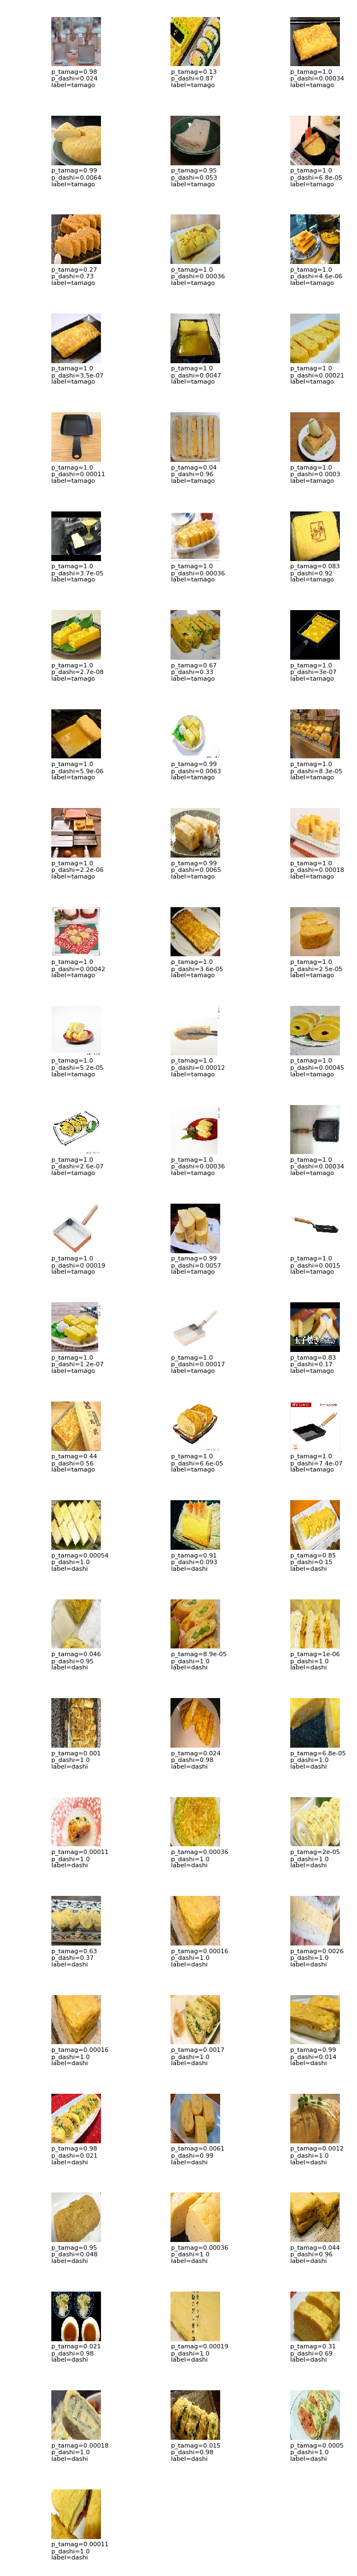

In [13]:
n_cols = 3
nrows = len(labels) // n_cols
if len(labels) % n_cols:
    nrows+= 1
    
    
fig = plt.figure(figsize=(n_cols,nrows),dpi=200)

for i, (label, prob) in enumerate(zip(labels, probs)):
    plt.subplot(nrows, n_cols, i+1)
    plt.imshow(imgs[i])
    p_dashi = prob[0]
    p_tamag = prob[1]
    answer = {
        0: 'dashi',
        1: 'tamago'
    }[label]
    plt.text(0, 180,
             f"p_tamag={p_tamag:.2}\np_dashi={p_dashi:.2}\nlabel={answer}",
            fontsize=4)
    plt.axis('off')

plt.subplots_adjust(left=1, bottom=0, right=2, top=None, wspace=0.3, hspace=1)